In [14]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
colors=cm.coolwarm(np.linspace(1, 0, 500)) # red first
import diffmah
from diffmah import mah_halopop, DEFAULT_MAH_PARAMS
from jax import grad
import jax.numpy as jnp
from jax import vmap 
from tqdm.autonotebook import tqdm

In [15]:
def diffmah_model(theta, tarr):
    logtc = theta["logtc"]
    early = theta["early"]
    late = theta["late"]

    ZZ = jnp.zeros(1)
    
    logt0 = jnp.log10(tarr[-1])

    #fixed parameters
    logm0_arr = 13. + ZZ
    t_peak_arr = 14.0 + ZZ

    #fitting parameters
    logtc_arr = logtc + ZZ
    early_arr = early + ZZ
    late_arr = late + ZZ


    mah_params = DEFAULT_MAH_PARAMS._make((logm0_arr, logtc_arr, early_arr, late_arr, t_peak_arr))
    dmhdt, log_mah = mah_halopop(mah_params, tarr, logt0)

    return log_mah[0]

In [16]:
tarr = np.linspace(0.5, 13.8, 100)

mhalo_true = diffmah_model(dict(logtc=jnp.log10(2), early=2, late=1), tarr)

logtc_rand = np.random.uniform(jnp.log10(0.5),np.log10(5))
early_rand = np.random.uniform(0.1,10)
late_rand = np.random.uniform(0.1,5)

print(f'logtc_rand: {logtc_rand}\nearly_rand: {early_rand}\nlate_rand: {late_rand}')
mhalo_guess = diffmah_model(dict(logtc=logtc_rand, early=early_rand, late=late_rand), tarr)

logtc_rand: 0.46429111997420824
early_rand: 5.082770924950723
late_rand: 4.854905853674075


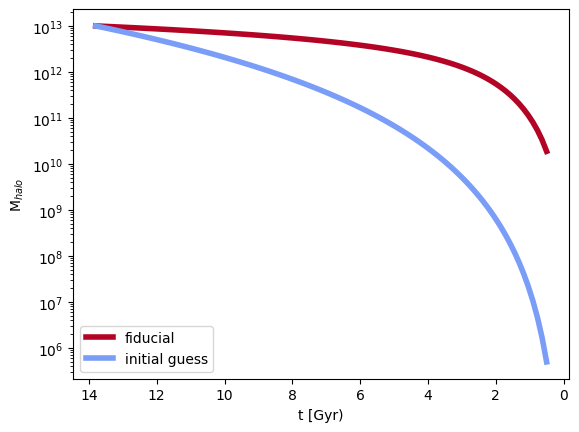

In [17]:
fig, ax = plt.subplots(1, 1)
__=ax.semilogy()
__=ax.invert_xaxis()
__=ax.plot(tarr, 10**mhalo_true, color=colors[0], label='fiducial', lw=4)
__=ax.plot(tarr, 10**mhalo_guess, color=colors[400], label='initial guess', lw=4)


ax.set_xlabel('t [Gyr)')
ax.set_ylabel('M$_{halo}$')
plt.legend()
plt.show()

In [18]:
def mse(mhalo_true: jnp.ndarray, mhalo_pred: jnp.ndarray) -> float:
    """Mean squared error function."""
    return jnp.mean(jnp.power(mhalo_true - mhalo_pred, 2))

In [19]:
def mseloss(theta, model, tarr, mhalo_true):
    mhalo_pred = model(theta, tarr)
    return mse(mhalo_true, mhalo_pred)

In [20]:
dmseloss = grad(mseloss)

In [21]:
dmseloss(dict(logtc=jnp.log10(3.), early=1., late=2.), diffmah_model, tarr, mhalo_true) 

{'early': Array(-0.11640245, dtype=float32, weak_type=True),
 'late': Array(0.02645773, dtype=float32, weak_type=True),
 'logtc': Array(0.01625249, dtype=float32)}

In [22]:
def model_optimization_loop(theta, model, loss, dloss, tarr, mhalo_true, n_steps=10000, step_size=0.01):
    
    losses = []

    for i in tqdm(range(n_steps)):
        
        grads = dloss(dict(logtc=theta["logtc"], early=theta["early"], late=theta["late"]), model, tarr, mhalo_true)
        
        theta["logtc"] = theta["logtc"] - step_size*grads["logtc"]
        theta["early"] = theta["early"] - step_size*grads["early"]
        theta["late"]  = theta["late"]  - step_size*grads["late"]

        losses.append(loss(dict(logtc=theta["logtc"], early=theta["early"], late=theta["late"]), model, tarr, mhalo_true))

    return losses, theta

In [23]:
losses, theta = model_optimization_loop(dict(logtc=logtc_rand, early=early_rand, late=late_rand),
                                             diffmah_model, mseloss, dmseloss, tarr, mhalo_true)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
mhalo_fit = diffmah_model(dict(logtc=theta["logtc"], early=theta["early"], late=theta["late"]), tarr)

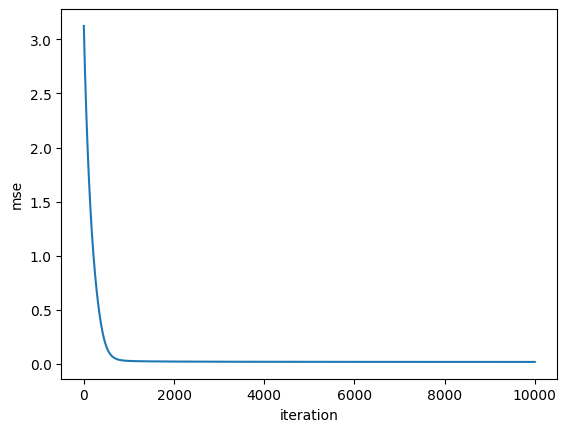

In [25]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('mse')
plt.show()

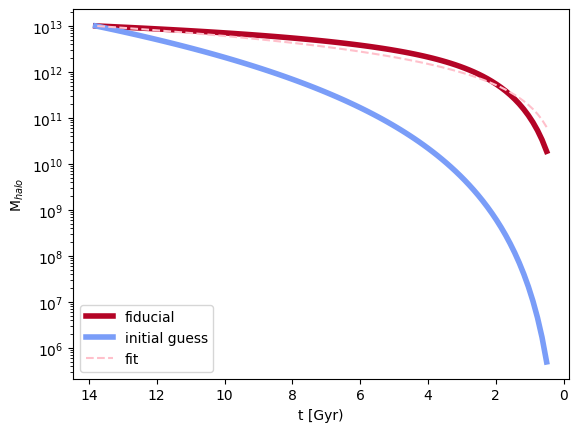

In [26]:
fig, ax = plt.subplots(1, 1)
__=ax.semilogy()
__=ax.invert_xaxis()
__=ax.plot(tarr, 10**mhalo_true, color=colors[0], label='fiducial', lw=4)
__=ax.plot(tarr, 10**mhalo_guess, color=colors[400], label='initial guess', lw=4)
__=ax.plot(tarr, 10**mhalo_fit, color='pink', ls='--', label='fit')



ax.set_xlabel('t [Gyr)')
ax.set_ylabel('M$_{halo}$')
plt.legend()
plt.show()